# TP2 MI204 - Classification et Aprentissage

CARVALHO FRULANE DE SOUZA Daniel 

GALVÃO Mateus

TAULOIS BRAGA Bernardo

## Préliminaires informatiques

### Importation des librairies pertinentes

In [2]:
import numpy as np
import cv2
import sys
import os

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

### Lecture de l'image et récuperation des composantes

Ce code sépare l'image en plusieurs types de composantes :

#### Espace RGB

Ces composantes sont modélisées comme trois vecteurs dont les valeurs répresentent l'intensité des couleurs primaires, c'est-à-dire, rouge, vert et bleu. Ces composantes sont additives, alors il est possible de répresenter presque n'importe quelle couleur avec ces trois valeurs. En revanche, des experiments de "color matching" ont demontré que certaines couleurs ne peuvent pas être exactement réproduites avec une synthèse additive à partir des composantes primaires. Ces composantes ne sont pas invariantes à l'illumination, mais les composantes normalisées sont invariantes colométriques.

#### Espace HSV

Ces composantes essaient de modéliser les couleurs de façon plus proche de la perception humaine. La composante teinte répresente la couleur dominante d'un point et couvre tout le Cercle de Newton. La composante saturation répresente la pureté de cette couleur et varie entre une couleur pure et un niveau de gris. Enfin, la composante valeur répresente l'intensité de la couluer, variant entre le noir et le blanc absolus. La composante H (teinte) est invariante, mais les composantes S et V ne le sont pas. D'ailleurs, cette composante n'est pas très significative pour les régions peu saturées, c'est-à-dire, très claires ou très sombres. 

#### Espace YUV

Dans ce cas, la composante Y répresente la luminance, tandis que les composantes U et V répresentent les composantes bleue et rouge en coordonées réduites.

In [4]:

img_bgr=cv2.imread("Parrots.jpg")

(h,w,c) = img_bgr.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes x",c,"canaux")

b,g,r = cv2.split(img_bgr) # On récupère les 3 composantes   
img_rgb = cv2.merge([r,g,b]) # Convention matplotlib  

img_hsv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(img_hsv) # On récupère les 3 composantes

img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
y,cr,cb = cv2.split(img_yuv) # On récupère les 3 composantes


Dimension de l'image : 348 lignes x 480 colonnes x 3 canaux


### Affichage des images

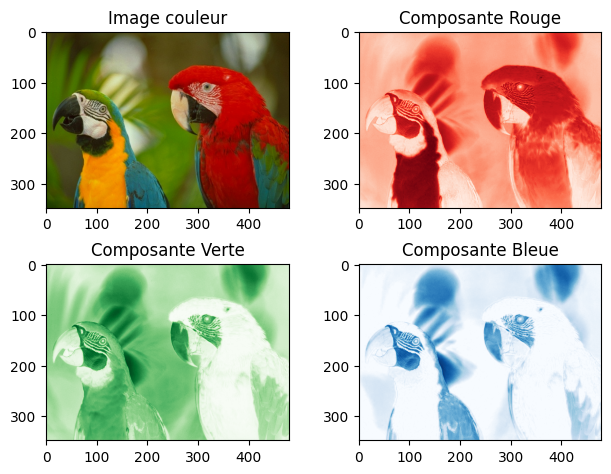

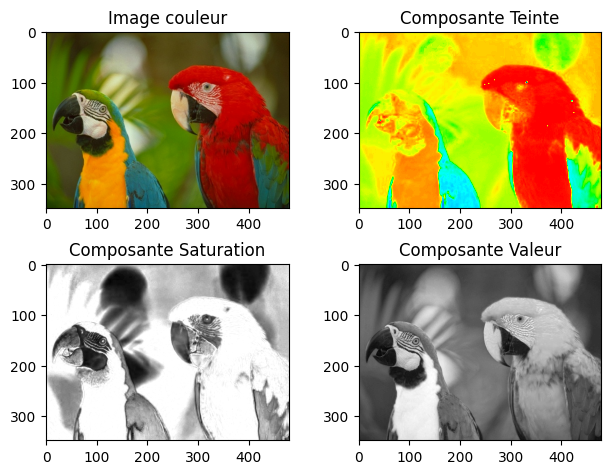

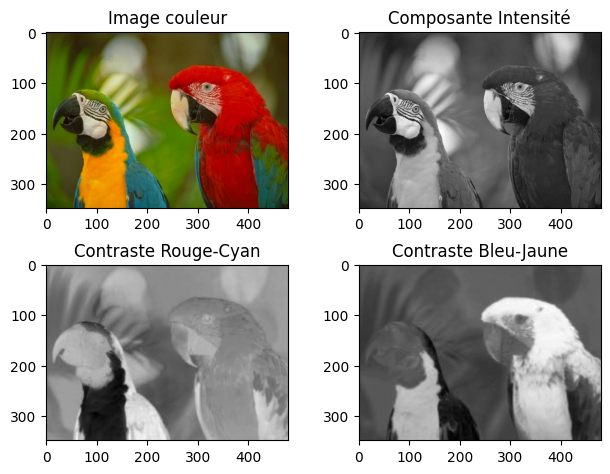

In [7]:
#Affichage des composantes RGB
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(r,cmap = 'Reds')
plt.title('Composante Rouge')
plt.subplot(223)
plt.imshow(g,cmap = 'Greens')
plt.title('Composante Verte')
plt.subplot(224)
plt.imshow(b,cmap = 'Blues')
plt.title('Composante Bleue')
plt.tight_layout()
plt.show()

#Affichage des composantes HSV
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(h,cmap = 'hsv')
plt.title('Composante Teinte')
plt.subplot(223)
plt.imshow(s,cmap = 'gray')
plt.title('Composante Saturation')
plt.subplot(224)
plt.imshow(v,cmap = 'gray')
plt.title('Composante Valeur')
plt.tight_layout()
plt.show()

#Affichage des composantes YUV
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(y,cmap = 'gray')
plt.title('Composante Intensité')
plt.subplot(223)
plt.imshow(cr,cmap = 'gray')
plt.title('Contraste Rouge-Cyan')
plt.subplot(224)
plt.imshow(cb,cmap = 'gray')
plt.title('Contraste Bleu-Jaune')
plt.tight_layout()
plt.show()

## Principes de la classification bayésienne

Dans le cadre de l'aprentissage bayésienne, on peut choisir parmi deux critères pour optimiser l'estimation :

### Critère du Maximum de Vraisemblance (ML)

Dans ce cas, on essaie de maximiser la fonction de vraisemblance d'une distribution présumée. Cette fonction est définie comme, étant donné les données d'observation $X$ et le paramètre de la distribution $c$ :

$$ c \rightarrow L_n(c;x_1,...,x_n) = P(X|c) = \prod_{i=1}^{n}f_c(x_i) $$

Vu que les observations sont indépendentes et ont comme distribution $f_c(x)$. Ainsi, l'objectif est :

$$ c^{*}(X) = \arg\max_{c} P(X|c) $$

### Critère du Maximum _a posteriori_ (MAP)

Dans ce cas, on associe au paramètre $c$ une distribution _a priori_ $P(c)$. Ainsi, on en obtient, à partir de la Loi de Bayes, sa distribution _a posteriori_ :

$$ P(c|X) = \frac{P(X|c)P(c)}{P(X)} $$

On cherche alors le paramètre $c$ le plus probable après les observations $X$. Ainsi, l'objectif est :

$$ c^{*}(X) = \arg\max_{c} P(c|X) = \arg\max_{c} P(X|c)P(c) = \arg\max_{c} \log P(X|c) + \log P(c) $$

Car la fonction logarithme est monotone. Ainsi, ce qui distingue le ML du MAP est le poids donné à la loi _a priori_. Ainsi, ces fonctions doivent être prises en compte par le code et soit choisies de façon arbitraire soit de façon a minimiser l'information _a priori_.

## Classification de caractéristiques locales

### Classification bayésienne des pixels

#### Application dans un exemple

En utilisant le code "Bayes_Model_Training.py" avec l'image "Parrots.jpg" pour 2 classes, il est possible de choisir les batchs de façon que nous pouvons apercevoir la discrimination des coleurs des classes. Dans les deux images suivantes, nous avons essayé de discretiser l'image original entre les classes représentés majeurement par la coleur vert, rouge, bleue, et jaune, respectivement.

![Green](green.png)
![Red](red.png)
![Blue](blue.png)
![Yellow](yellow.png)

Nous pouvons apercevoir que les résultats sont complementaires dans les régions de prédominance d'une des couleurs discretisées, avec la différence determiné par la choix des batchs dans la phase de entraînement et les caractéristiques de l'image.

Le nombre de classes meilleur adapté à notre tâche sera le nombre de couleurs à distinguer parmi les images choisies (dans l'exemple donnée, deux: la couleur choisie et le reste). Les espaces d'observations meilleur adaptés à notre tâche seront les valeurs d'intensité des pixels dans le spectre RGB, sachant qu'il faut distinguer les couleurs désirées dans ce espace.

### Difficultés du modèle
Une difficulté potentielle de notre programme c'est la bonne choix des batchs pour la modélisation du entraînement, sachant qu'ils sont limités pour les critères imposées par l'utilisateur et par la choix rectangulaire des batchs. La classification bayésienne des pixels repose sur les distributions de probabilité des intensités de pixels pour chaque classe, alors choisir des batchs appropriés sans erreur de compatibilité du nombre de samples dans les cas où la distribution des données est complexe ou inconnue pourra être difficile. Ou encore, si la quantité de données d'entraînement disponibles est faible, les modèles de classification bayésienne de pixels peuvent souffrir d'un surajustement, ou encore mal interpréter le bruit dans les données d'entraînement plutôt que les modèles sous-jacents, ce qui entraîne de mauvaises performances de généralisation.

### Comparaison des modèles
#### Modèle bayésien gaussien naïf
Dans ce modèle, il est supposé que toutes les caractéristiques (dimensions) sont indépendantes compte tenu de l'étiquette de classe. Cela signifie que la présence d’une fonctionnalité n’affecte pas la présence d’une autre fonctionnalité. Le calcule des distributions gaussiennes distinctes pour chaque entité rendre un modèle moins complexe et des calculs plus efficients.

#### Modèle bayésien gaussien multidimensionnel
Dans ce modèle, il n'y a aucune hypothèse d'indépendance des caractéristiques, parce qu'il permet des corrélations entre les fonctionnalités. Cela signifie que la distribution conjointe de toutes les entités est modélisée à l'aide d'une distribution gaussienne multivariée, en donnant des calculs plus coûteuses.

### Amélioration du modèle

Le modèle pourra être amélioré avec l'implantation de techniques de traitement d'image en conjonction au traitement bayésien. Par exemple, la considération de features de texture et forme en classes, avec l'usage de détecteurs et descripteurs, pourra éviter le surajustement.

### Classification non supervisée des pixels par K-Means

Le K-means est un algorithme de clustering largement utilisé en apprentissage automatique et en analyse de données. Il est utilisé pour regrouper un ensemble de données en k clusters distincts, où k est un nombre pré-défini par l'utilisateur. L'objectif de l'algorithme K-means est de trouver des centroïdes (ou moyennes) pour chaque cluster, de sorte que la distance entre les points de données et les centroïdes soit minimisée.

Ensuite, nous examinerons la classification d'images en utilisant une méthode non supervisée par K-Means, d'abord en ce qui concerne la photo des perroquets ("Parrots.png") et en faisant varier le nombre de classes. De plus, la partie du code responsable de réaliser le test en utilisant la même image que celle de l'entraînement a été développée.

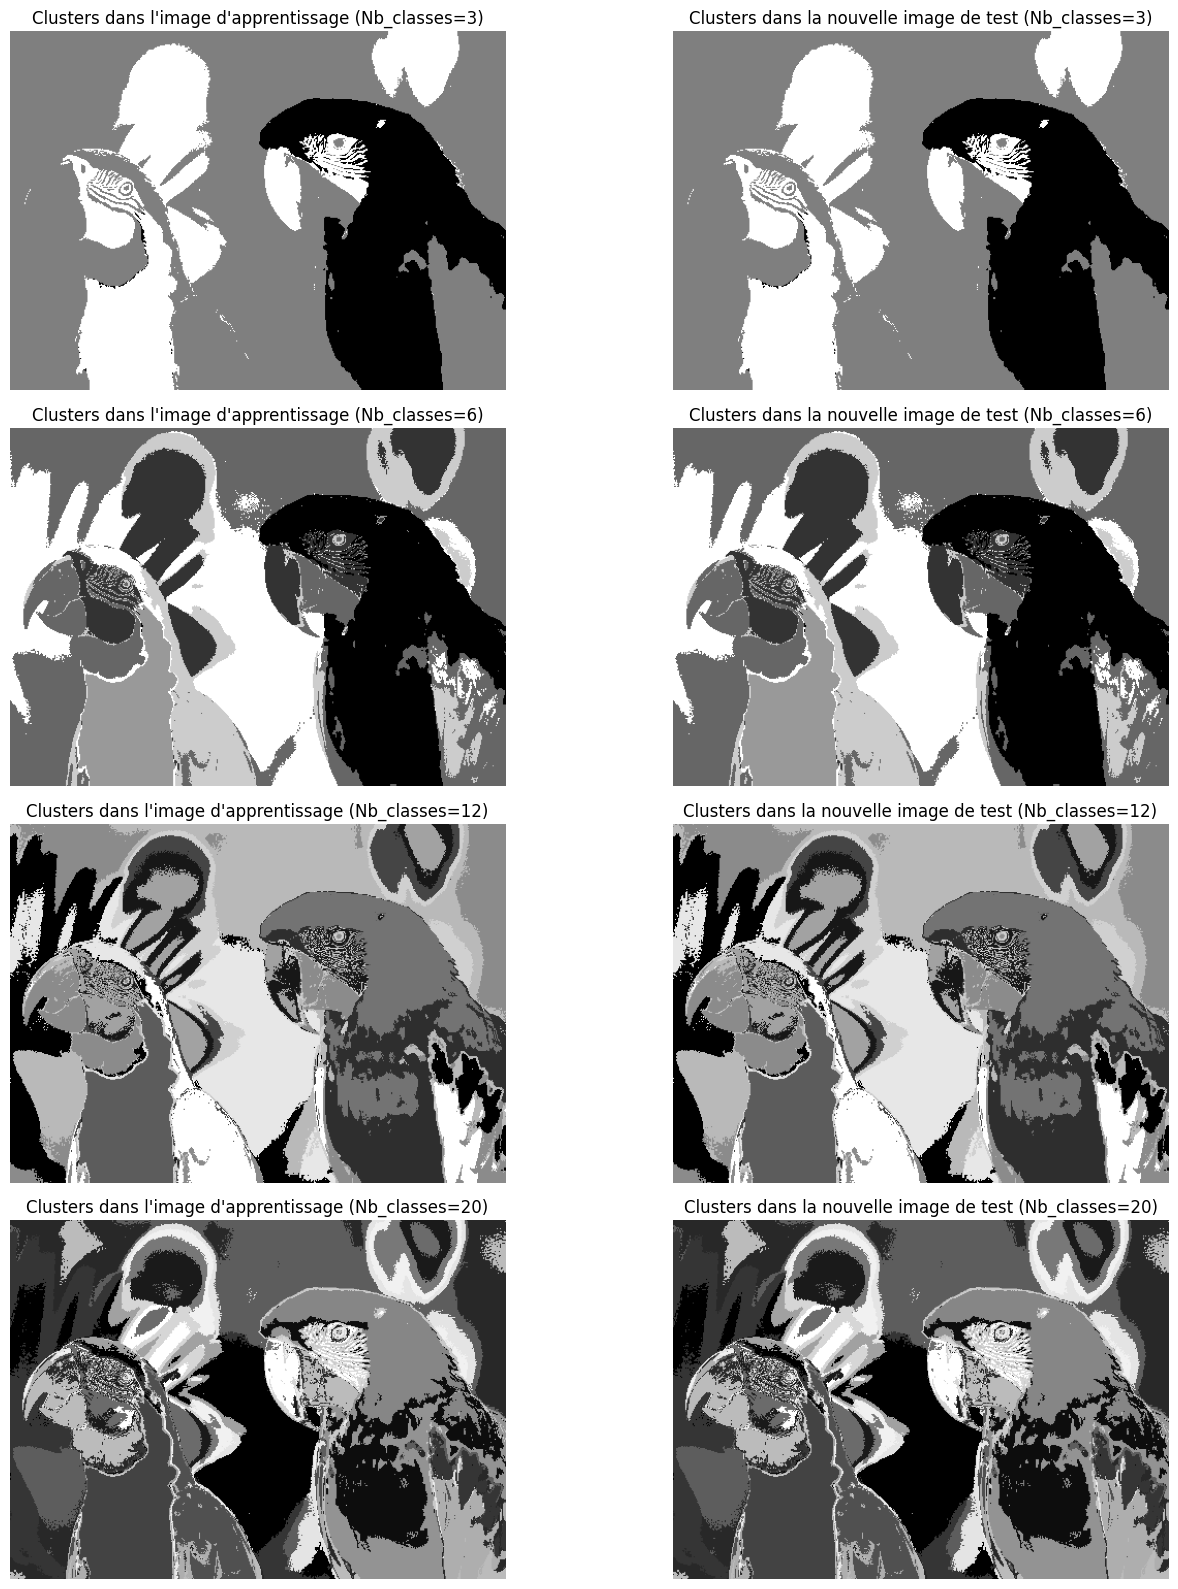

In [41]:
# Charger l'image
img_bgr = cv2.imread('Parrots.jpg')
(h_img, w_img, c) = img_bgr.shape

# Définir différentes valeurs de Nb_classes
nb_classes_list = [3, 6, 12, 20]

plt.figure(figsize=(15, 16))

for i, Nb_classes in enumerate(nb_classes_list, start=1):
    # Clustering K-means
    img_samples = np.reshape(img_bgr, (-1, 3))
    kmeans = KMeans(n_clusters=Nb_classes, n_init=10, random_state=0).fit(img_samples)
    
    # Étiquettes et affichage pour l'image d'entraînement
    img_labels = np.reshape(kmeans.labels_, (h_img, w_img))
    img_labels_display = (img_labels * 255) / (Nb_classes - 1)
    img_labels_display = img_labels_display.astype(np.uint8)


    plt.subplot(len(nb_classes_list), 2, i*2-1)
    plt.imshow(cv2.cvtColor(img_labels_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Clusters dans l'image d'apprentissage (Nb_classes={Nb_classes})")
    plt.axis('off')

    # Test sur la même image
    new_img_bgr = cv2.imread('Parrots.jpg')
    new_img_bgr = cv2.resize(new_img_bgr, (w_img, h_img))
    new_img_samples = np.reshape(new_img_bgr, (-1, 3))
    new_img_labels = kmeans.predict(new_img_samples)
    new_img_labels_display = np.reshape(new_img_labels, (h_img, w_img))
    new_img_labels_display = (new_img_labels_display * 255) / (Nb_classes - 1)
    new_img_labels_display = new_img_labels_display.astype(np.uint8)

    plt.subplot(len(nb_classes_list), 2, i*2)
    plt.imshow(cv2.cvtColor(new_img_labels_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Clusters dans la nouvelle image de test (Nb_classes={Nb_classes})")
    plt.axis('off')

plt.tight_layout()
plt.show()


Comme nous pouvons le constater, pendant l'entraînement, l'algorithme K-means identifie des modèles dans les données d'entraînement (qui sont les pixels de l'image) et regroupe ces pixels en clusters en fonction de leurs caractéristiques, telles que la couleur, la texture, l'intensité, etc. Les centroïdes de ces clusters représentent les caractéristiques dominantes trouvées dans les données d'entraînement.

En appliquant ces clusters à une nouvelle image (ou à la même image originale dans ce cas), l'algorithme K-means attribue chaque pixel à l'un des clusters en fonction de sa similarité avec les centroïdes des clusters. L'image finale générée affiche ces clusters comme des régions de couleurs ou d'intensités différentes, mettant en évidence les caractéristiques apprises lors de l'entraînement.

Dans le code développé, la variation de `Nb_classes` pour des valeurs plus élevées permet d'obtenir une image plus claire des perroquets et plus proche de l'originale utilisée pour l'entraînement et le test. Cela s'explique par le fait que, pour des images comme celle des perroquets, qui présentent de nombreuses variations de couleur et de texture, un plus grand nombre de classes peut être nécessaire pour capturer avec précision les détails de l'image, car l'algorithme K-means a besoin de clusters suffisants pour représenter adéquatement les différentes régions de l'image, chacune avec ses propres caractéristiques de couleur et de texture.

Ensuite, nous ferons la même analyse, mais cette fois-ci en utilisant un visage de personne et en effectuant le test avec un visage différent du premier, comme nous pouvons le voir ci-dessous :

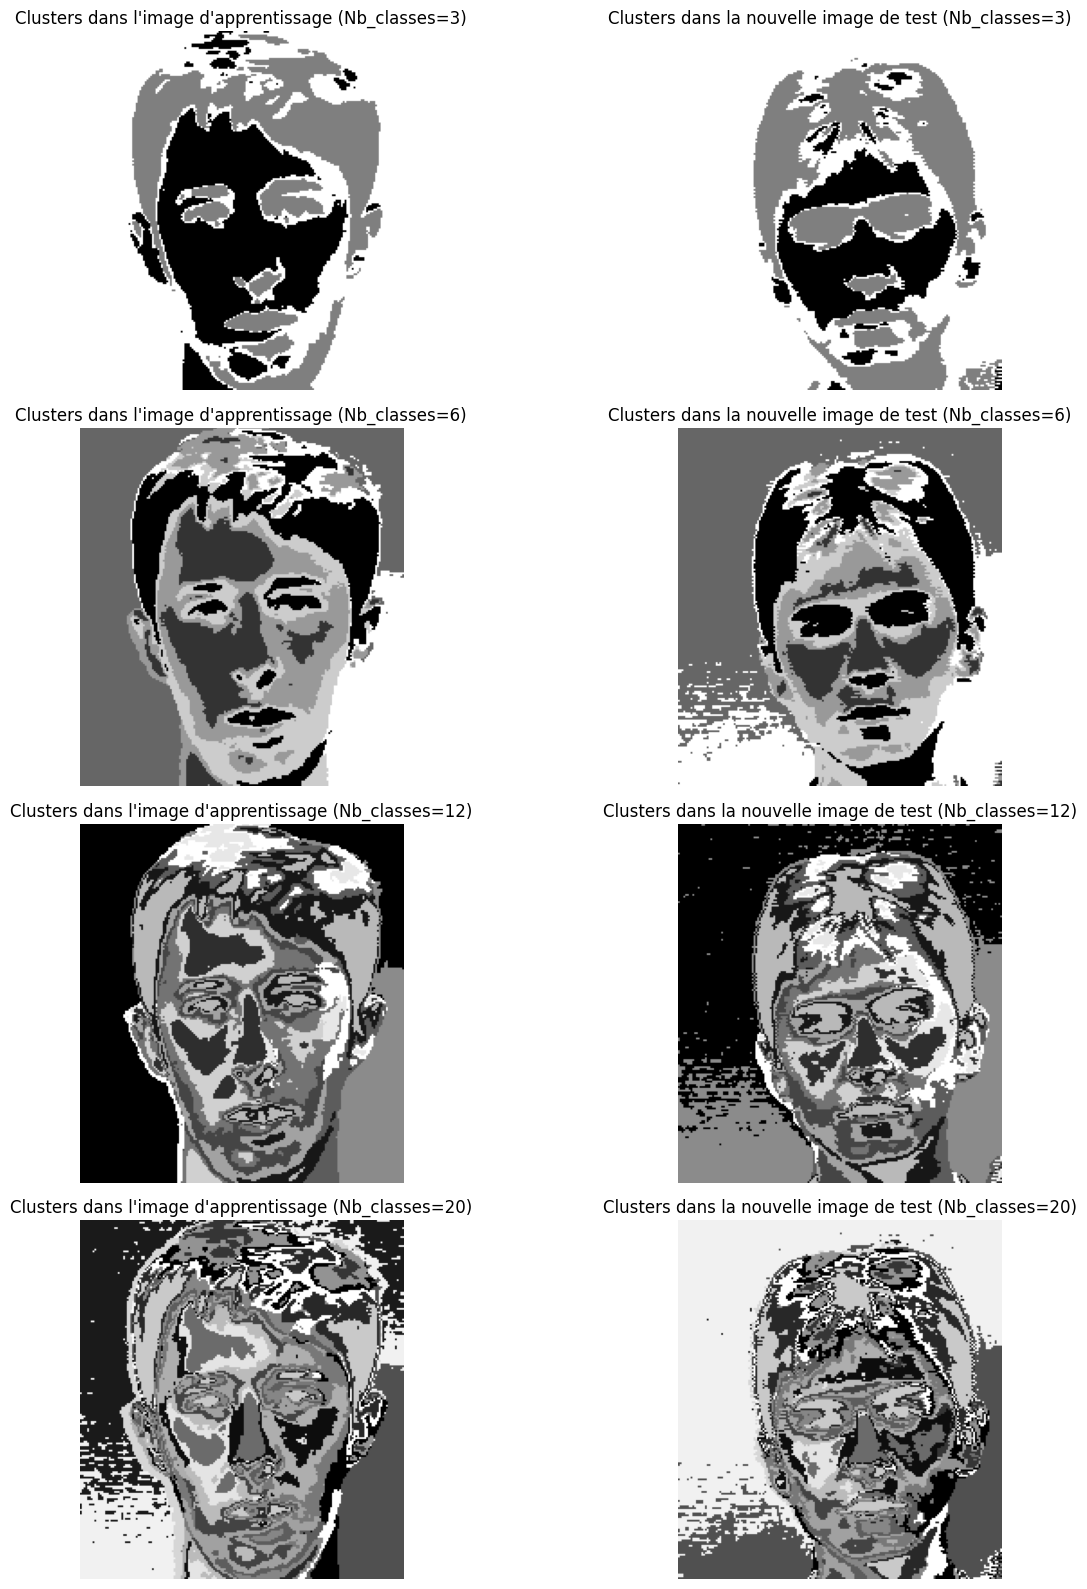

In [42]:
# Charger l'image
img_bgr = cv2.imread('Images_Classif/Essex_Faces/94/ajsega.19.jpg')
(h_img, w_img, c) = img_bgr.shape

# Définir différentes valeurs de Nb_classes
nb_classes_list = [3, 6, 12, 20]

plt.figure(figsize=(15, 16))

for i, Nb_classes in enumerate(nb_classes_list, start=1):
    # Clustering K-means
    img_samples = np.reshape(img_bgr, (-1, 3))
    kmeans = KMeans(n_clusters=Nb_classes, n_init=10, random_state=0).fit(img_samples)
    
    # Étiquettes et affichage pour l'image d'entraînement
    img_labels = np.reshape(kmeans.labels_, (h_img, w_img))
    img_labels_display = (img_labels * 255) / (Nb_classes - 1)
    img_labels_display = img_labels_display.astype(np.uint8)


    plt.subplot(len(nb_classes_list), 2, i*2-1)
    plt.imshow(cv2.cvtColor(img_labels_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Clusters dans l'image d'apprentissage (Nb_classes={Nb_classes})")
    plt.axis('off')

    # Test sur une nouvelle image
    new_img_bgr = cv2.imread('Images_Classif/Essex_Faces/94/ccjame.19.jpg')
    new_img_bgr = cv2.resize(new_img_bgr, (w_img, h_img))
    new_img_samples = np.reshape(new_img_bgr, (-1, 3))
    new_img_labels = kmeans.predict(new_img_samples)
    new_img_labels_display = np.reshape(new_img_labels, (h_img, w_img))
    new_img_labels_display = (new_img_labels_display * 255) / (Nb_classes - 1)
    new_img_labels_display = new_img_labels_display.astype(np.uint8)

    plt.subplot(len(nb_classes_list), 2, i*2)
    plt.imshow(cv2.cvtColor(new_img_labels_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Clusters dans la nouvelle image de test (Nb_classes={Nb_classes})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Dans les images ci-dessus, nous pouvons voir que la meilleure configuration a été obtenue en utilisant le modèle de 6 classes, car pour les images de visages de personnes, qui ont généralement moins de variations de couleur et de texture par rapport à d'autres images plus complexes, comme avec des perroquets, un nombre plus restreint de classes peut être plus approprié. Un nombre excessif de classes peut entraîner une segmentation trop détaillée ou un chevauchement de clusters dans des régions similaires, ce qui peut aboutir à une image finale confuse ou sans signification. Ainsi, des séries de tests doivent être effectuées pour vérifier la meilleure configuration de `Nb_classes`, tout comme cela a été fait dans ce cas.

En conclusion, en faisant une comparaison entre les deux méthodes, le K-means est plus simple à mettre en œuvre et peut être plus efficace pour de grands ensembles de données, mais il nécessite de spécifier le nombre de clusters à l'avance et peut être sensible à l'initialisation des centroids. Cependant que le modèle bayésien offre une approche probabiliste plus flexible, capable de capturer des relations complexes entre les caractéristiques, mais il nécessite des hypothèses sur la distribution des données et peut être plus coûteux en termes de calcul, en particulier pour les modèles multidimensionnels.